In [1]:
import h5py
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from torchsummary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [2]:
from joblib import dump, load
from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, c, s, m, y):
        self.w = w
        self.c = c
        self.s = s
        self.m = m
        self.y = y
            
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
            
        ww = torch.tensor(self.w[idx], dtype=torch.long, device = device)
        cc = torch.tensor(self.c[idx], dtype=torch.long, device = device)
        ss = torch.tensor(self.s[idx], dtype=torch.long, device = device)
        mm = torch.tensor(self.m[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, cc, ss, mm, yy)

In [4]:
class MyNet(nn.Module):

    def __init__(self, w_layers, c_layers, s_layers, pred_layers):

        super().__init__()

                
        # Weaher variables
        w_layers_list = nn.ModuleList()
        for i, o, d in w_layers:
            w_layer = nn.Sequential(
                nn.Embedding(i, o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        self.w_layers = nn.Sequential(*w_layers_list)

        # Cell variables
        c_layers_list = nn.ModuleList()
        for i, o, d in c_layers:
            c_layer = nn.Sequential(
                nn.Embedding(i, o),
                nn.Dropout(d)
            )
            c_layers_list.append(c_layer)
        self.c_layers = nn.Sequential(*c_layers_list)

                
        # Soil variables
        s_layers_list = nn.ModuleList()
        for i, o, d in s_layers:
            s_layer = nn.Sequential(
                nn.Embedding(i, o),
                nn.Dropout(d)
            )
            s_layers_list.append(s_layer)
        self.s_layers = nn.Sequential(*s_layers_list)
        
        
        # Management variables
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.ReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws, Cs, Ss, Ms):

        Ws = Ws.view(Ws.shape[0], -1)
        Cs = Cs.view(Cs.shape[0], -1)
        Ss = Ss.view(Ss.shape[0], -1)
        Ms = Ms.view(Ms.shape[0], -1)
        
        W_feat = self.w_layers(Ws.long()).view(Ws.shape[0], -1)
        C_feat = self.c_layers(Cs.long()).view(Cs.shape[0], -1)
        S_feat = self.s_layers(Ss.long()).view(Ss.shape[0], -1)
        
        all_feats = torch.cat([W_feat, C_feat, S_feat, Ms], dim = 1)
        pred = self.pred_layers(all_feats)
        return (pred)


In [5]:
ydf = pyreadr.read_r('/home/rodrigo7/Documents/APSIMDL/original/yield.rds')[None]


In [38]:
cvars = ['dul_dep', 'll15_dep', 'whc', 'leach_n', 'n_top15_delta', 
         'rain_30', 'rain_60', 'rain_90', 't_max_30', 't_max_60', 't_max_90', 't_min_30', 't_min_60', 't_min_90',
         'day_sow', 'day_v5', 'sw_dep_v5', 'biomass_v5', 'lai_v5', 'oc_20cm_v5', 'oc_40cm_v5',
         'n_20cm_v5', 'n_40cm_v5', 'n_60cm_v5', 'n_deep_v5', 'esw_pct_v5', 'biomass_n_v5',
         'green_biomass_n_v5', 'greenn_v5', 'leafgreennconc_v5']
 

In [6]:
# data_file = '/home/rodrigo7/Documents/APSIMDL/train.h5'
# hdf5_file = h5py.File(data_file, mode='r')
# weather_df = hdf5_file.get('weather')
# print(weather.shape)

In [7]:
# data_file = '/home/rodrigo7/Documents/APSIMDL/train.h5'
# hdf5_file = h5py.File(data_file, mode='r')
# soil_df = hdf5_file.get('soils')
# soil_df = np.array(soil_df).reshape(soil_df.shape[0], -1)
# print(soil_df.shape)

In [11]:
ydf["W"] = ydf.z.astype('category').cat.codes
ydf["C"] = ydf.id_10.astype('category').cat.codes
ydf["S"] = ydf.mukey.astype('category').cat.codes


In [13]:
Y_data = ydf.Yld.values.reshape(-1,1)
sc = StandardScaler()
Y_std = sc.fit(Y_data)
Y = Y_std.transform(Y_data)
dump(Y_std, '../data/Y_std.bin', compress=True)
print(Y.shape)

(4846544, 1)


In [39]:
M_data = ydf.loc[:,cvars].values
M_std = sc.fit(M_data)
M = M_std.transform(M_data)
dump(M_std, '../data/M_std.bin', compress=True)
print(M.shape)

(4846544, 30)


In [43]:
# N_data = ydf.N_fert.values.reshape(-1,1)
# sc = StandardScaler()
# N_std = sc.fit(N_data)
# N = N_std.transform(N_data)
# dump(N_std, '../data/N_std.bin', compress=True)
# print(N.shape)

In [44]:
W = ydf.W.values.reshape(-1,1)
C = ydf.C.values.reshape(-1,1)
S = ydf.S.values.reshape(-1,1)

In [45]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.01, train_size= 0.1, random_state=123456)
xidx = np.arange(len(W))
train_idx, val_idx = next(gss.split(xidx, groups=W))
train_idx.shape, val_idx.shape

((477378,), (168828,))

In [46]:
batch_size = 1000


pred_dataset = MyDataset(W, C, S, M, Y)
train_dataset = MyDataset(W[train_idx], C[train_idx], S[train_idx], M[train_idx], Y[train_idx])
val_dataset = MyDataset(W[val_idx], C[val_idx], S[val_idx], M[val_idx], Y[val_idx])


pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

data = iter(train_loader).next()
print(len(train_loader))



478


In [50]:
d = 0.1
w_layers = [(ydf.W.nunique(), 1, d)]
c_layers = [(ydf.C.nunique(), 50, d)]
s_layers = [(ydf.S.nunique(), 50, d)]
pred_layers = [[180,32,d],[32,16,d],[16,8,d], [8,4,d]]

model = MyNet(w_layers, c_layers, s_layers, pred_layers)
model = model.to(device)
# model.load_state_dict(torch.load('../data/model_v0.pth', map_location=device))
summary(model,  input_size=[(1,1), (1,1), (1,1), (30,1)])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                [-1, 1, 10]             300
           Dropout-2                [-1, 1, 10]               0
         Embedding-3                [-1, 1, 50]          61,200
           Dropout-4                [-1, 1, 50]               0
         Embedding-5                [-1, 1, 90]         252,090
           Dropout-6                [-1, 1, 90]               0
            Linear-7                   [-1, 32]           5,792
              ReLU-8                   [-1, 32]               0
       BatchNorm1d-9                   [-1, 32]              64
          Dropout-10                   [-1, 32]               0
           Linear-11                   [-1, 16]             528
             ReLU-12                   [-1, 16]               0
      BatchNorm1d-13                   [-1, 16]              32
          Dropout-14                   

In [51]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

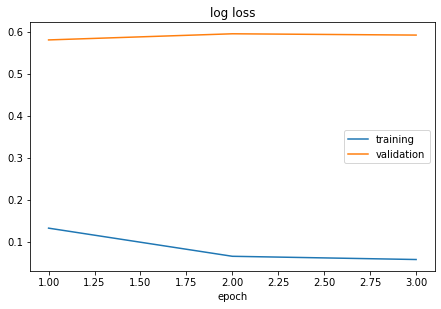

log loss:
training   (min:    0.057, max:    0.132, cur:    0.057)
validation (min:    0.580, max:    0.595, cur:    0.592)
[0:2] loss: 0.057 time:79.80


KeyboardInterrupt: 

In [52]:
min_loss = 1
bad_epochs = 0
liveloss = PlotLosses()
num_epochs = 150 # Define o número de épocas para realizar o treinamento 
for epoch in range(num_epochs):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Cs, Ss, Ms, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(Ws, Cs, Ss, Ms)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Cs, Ss, Ms, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws, Cs, Ss, Ms)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        model_file_name = '../data/model_v0.pth'
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [ ]:
model.load_state_dict(torch.load('../data/model_v0.pth', map_location=device))
print('Model OK')

In [ ]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (Ws, Cs, Ss, Ms, Ys) in enumerate(val_loader):
    obs.append(Ys.cpu().data.numpy())
    with torch.no_grad():
        pred = model(Ws, Cs, Ss, Ms)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))

In [ ]:
x = Y_std.inverse_transform(preds.reshape(-1))
y = Y_std.inverse_transform(obs.reshape(-1))

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()